In [6]:
!pip install statsmodels

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

In [8]:
df = pd.read_csv('SeaPlaneTravel.csv')


In [9]:
df.head()


,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [11]:
df['Month'] = pd.to_datetime(df['Month'])

In [12]:
indexed_df = df.set_index('Month')
ts = indexed_df['#Passengers']
ts.head(10)

Month
2003-01-01    112
2003-02-01    118
2003-03-01    132
2003-04-01    129
2003-05-01    121
2003-06-01    135
2003-07-01    148
2003-08-01    148
2003-09-01    136
2003-10-01    119
Name: #Passengers, dtype: int64

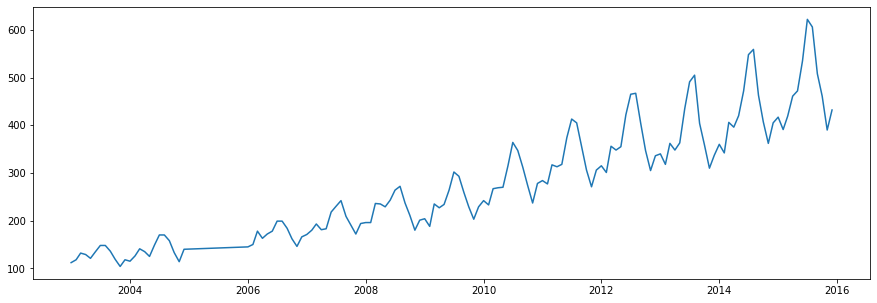

In [13]:
plt.figure(figsize=(15,5))
plt.plot(ts)
plt.show(block=False)

In [14]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12,center=False).mean()
    rolstd = timeseries.rolling(window=12,center=False).mean()
    #plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling mean and standard deviation')
    plt.show()
    
    #dicky-fuller test
    print('Results of dickey fuller test')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

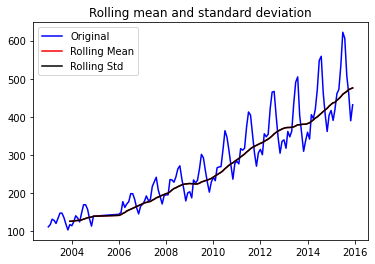

Results of dickey fuller test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
test_stationarity(ts)


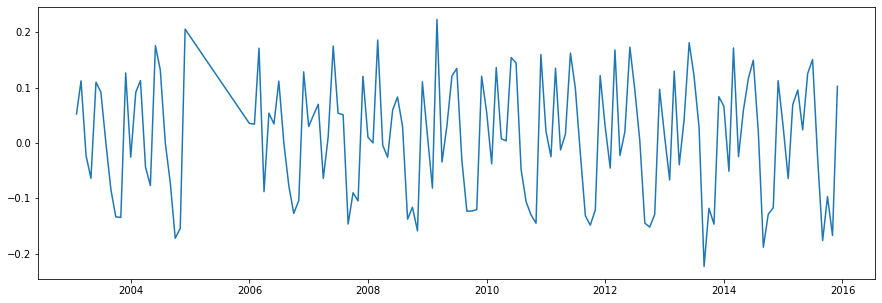

In [16]:
plt.figure(figsize=(15,5))
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

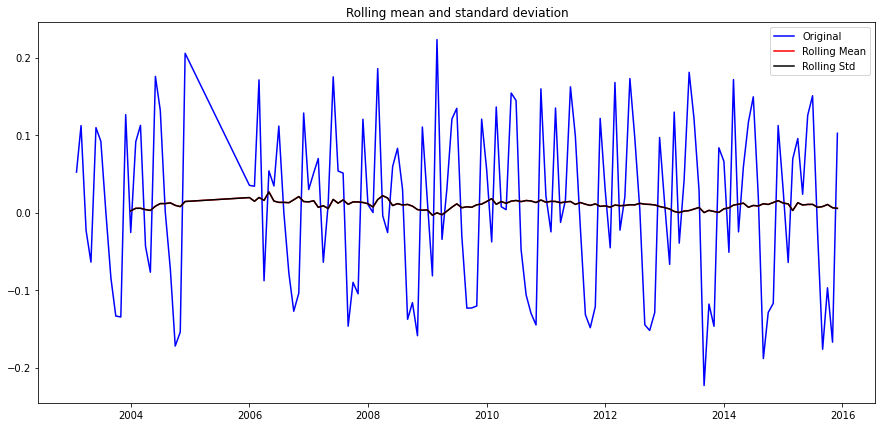

Results of dickey fuller test
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [17]:
plt.figure(figsize=(15,7))
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [18]:
lag_acf = acf(ts_log_diff, nlags = 10)
lag_pacf = pacf(ts_log_diff, nlags = 10, method='ols')

c:\users\tejshree reddy\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [19]:
lag_acf

array([ 1.        ,  0.19975134, -0.12010433, -0.15077204, -0.32207432,
       -0.08397453,  0.02577843, -0.11096075, -0.33672146, -0.11558631,
       -0.10926704])

In [20]:
lag_pacf

array([ 1.        ,  0.20081508, -0.17368194, -0.09901213, -0.33527437,
        0.00872185, -0.07990745, -0.21923579, -0.5421352 , -0.22848913,
       -0.64775301])

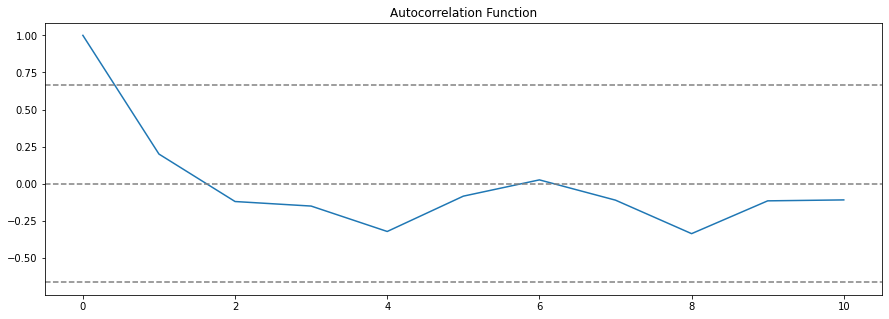

In [21]:
plt.figure(figsize=(15,5))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)),linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)),linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.show()

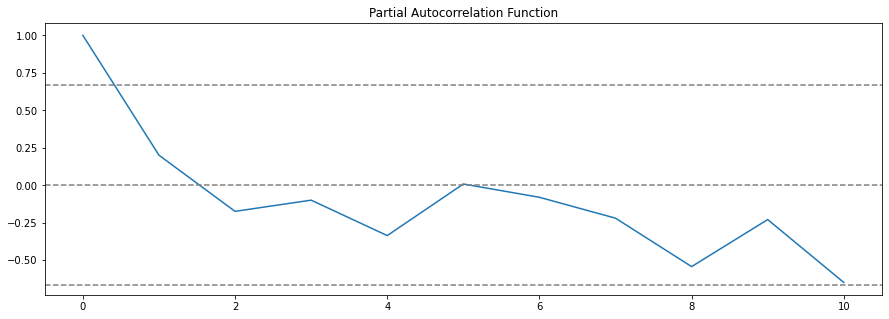

In [22]:
plt.figure(figsize=(15,5))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)),linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)),linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()


In [23]:
#Get 'p' value from PACF graph (where line intersects 0)
#get 'q' value from ACF graph (where it is intersecting upper confidence)

In [24]:
p = 2
q = 1
d = 1

In [25]:
testsize=15
train = ts_log[0:-15]
test = ts_log[-15:]
test

Month
2014-10-01    6.008813
2014-11-01    5.891644
2014-12-01    6.003887
2015-01-01    6.033086
2015-02-01    5.968708
2015-03-01    6.037871
2015-04-01    6.133398
2015-05-01    6.156979
2015-06-01    6.282267
2015-07-01    6.432940
2015-08-01    6.406880
2015-09-01    6.230481
2015-10-01    6.133398
2015-11-01    5.966147
2015-12-01    6.068426
Name: #Passengers, dtype: float64

In [26]:
history = [x for x in train]
prediction = []
history

[4.718498871295094,
 4.770684624465665,
 4.882801922586371,
 4.859812404361672,
 4.795790545596741,
 4.90527477843843,
 4.997212273764115,
 4.997212273764115,
 4.912654885736052,
 4.77912349311153,
 4.6443908991413725,
 4.770684624465665,
 4.74493212836325,
 4.836281906951478,
 4.948759890378168,
 4.90527477843843,
 4.8283137373023015,
 5.003946305945459,
 5.135798437050262,
 5.135798437050262,
 5.062595033026967,
 4.890349128221754,
 4.736198448394496,
 4.941642422609304,
 4.976733742420574,
 5.0106352940962555,
 5.181783550292085,
 5.093750200806762,
 5.147494476813453,
 5.181783550292085,
 5.293304824724492,
 5.293304824724492,
 5.214935757608986,
 5.087596335232384,
 4.983606621708336,
 5.111987788356544,
 5.14166355650266,
 5.19295685089021,
 5.262690188904886,
 5.198497031265826,
 5.209486152841421,
 5.384495062789089,
 5.438079308923196,
 5.488937726156687,
 5.342334251964811,
 5.25227342804663,
 5.147494476813453,
 5.267858159063328,
 5.278114659230517,
 5.278114659230517,
 5.4

In [27]:
history = [x for x in train]
prediction = []
for t in range(len(test)):
    model = ARIMA(history, order= (p,d,q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    prediction.append(float(yhat))
    actual_log = test[t]
    history.append(actual_log)
    print("Predicted Value", np.exp(yhat), "Actual Value", np.exp(actual_log))


c:\users\tejshree reddy\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Predicted Value [434.33565348] Actual Value 406.99999999999983
Predicted Value [412.89511483] Actual Value 362.00000000000017
Predicted Value [387.1393525] Actual Value 404.99999999999983
Predicted Value [455.89230835] Actual Value 417.0
Predicted Value [448.80736502] Actual Value 391.0
Predicted Value [416.15542634] Actual Value 418.9999999999999
Predicted Value [458.21903321] Actual Value 461.00000000000006
Predicted Value [492.11188033] Actual Value 471.99999999999983
Predicted Value [486.83147197] Actual Value 534.9999999999999
Predicted Value [548.71174293] Actual Value 621.9999999999999


c:\users\tejshree reddy\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\tejshree reddy\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\tejshree reddy\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\tejshree reddy\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Predicted Value [611.41860818] Actual Value 605.9999999999999
Predicted Value [564.05469694] Actual Value 508.00000000000006
Predicted Value [478.94703406] Actual Value 461.00000000000006
Predicted Value [468.2655945] Actual Value 390.00000000000006
Predicted Value [411.45811771] Actual Value 432.00000000000017


In [28]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test,prediction)

0.008352477804086583

In [29]:
predictions_series = pd.Series(prediction, index = test.index)


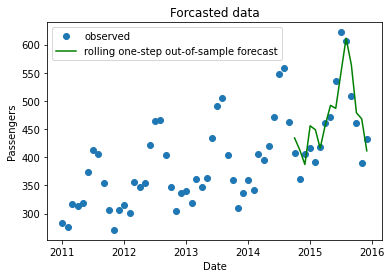

In [30]:
fig, ax = plt.subplots()
ax.set(title='Forcasted data', xlabel='Date', ylabel='Passengers')
ax.plot(ts[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')